# Hexagonal Cylinder Puzzle

Professor Bryan L. Shader of the University of Wyoming introduced us to this puzzle.
Bryan's father, the late Professor Leslie (Les) Shader, also of University of Wyoming, made a set of
puzzle pieces and passed them on to Bryan. Bryan is not aware of the origins of the puzzle. We presume
that Les Shader invented the puzzle.

The puzzle consists of 11 _pieces_ each consisting of `4` or `5` identical _blocks_ glued together.
Each _block_ is a regular hexagonal cylinder. When two blocks are glued together, they either share
a common (rectangular) face or share a common (hexagonal) base. The precise geometries of the pieces
are given below.

For simplicity, call the _height_ of each of these blocks `1`. For each piece, the total height
is `2`.

The goal is to place these pieces in the _puzzle space_ so they fill that space. The puzzle space
is an equilateral triangular cylinder of height `3`.


### The Pieces

Here's a picture of the pieces. There are 11 pieces labeled `1`, `2`, ..., `9`, `A`, `B`.
The label is marked on the _pivot block_ for the _piece_. The label also indicates the
_base orientation_ of the piece. Note that piece `2` has `5` blocks while all other pieces
have `4` blocks. There are a total of `45` blocks.


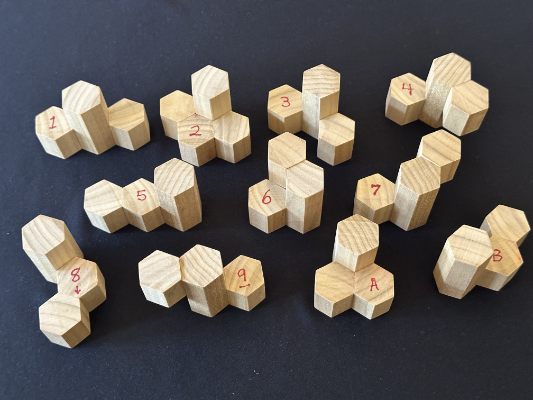

In [1]:
ImageSize := 400;
ReadPixels("../data/HexagonalPuzzlePieces.jpeg")->ResizePixels(ImageSize)

### One Solution

Here's a picture of one particular solution. This picture also illustrates the _puzzle space_.
The puzzle space is three blocks high. Each side of the triangle spans five blocks. The total
number of blocks that fit in the puzzle space is `45`.


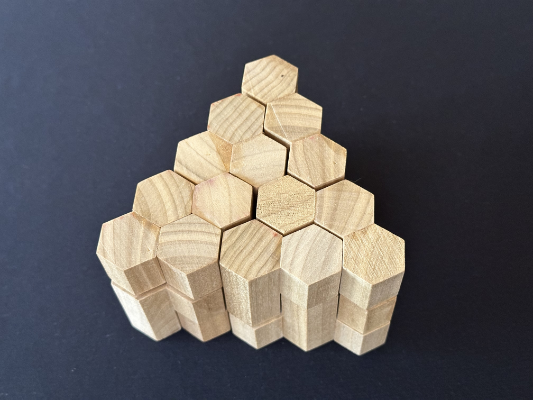

In [2]:
ReadPixels("../data/HexagonalPuzzleSolution.jpeg")->ResizePixels(ImageSize)

## Coordinate System

Our goal in this notebook is to find solutions to this puzzle using Rexl
and its SAT (boolean satisfiability) solver. To do that, we need a precise formulation
of the pieces and puzzle space. The first step is to define a coordinate system.

We label each block location (or _cell_) in the puzzle space with an `(A, B, C)` triple.
The bottom left cell of the lowest layer is `(0, 0, 0)`. The `A` value increases to
the right, the `C` value increases vertically through the layers, and the `B` value
increases along the left triangular edge.

The vertices of the triangular bottom layer are `(0, 0, 0)`, `(4, 0, 0)` and `(0, 4, 0)`,
in counter-clockwise order.
The vertices of the triangular middle layer are `(0, 0, 1)`, `(4, 0, 1)` and `(0, 4, 1)`,
in counter-clockwise order.
The vertices of the triangular top layer are `(0, 0, 2)`, `(4, 0, 2)` and `(0, 4, 2)`,
in counter-clockwise order.

More precisely, using `(X, Y, Z)` for standard Euclidean coordinates, the puzzle coordinate
system `(A, B, C)` is defined by:

* `X = A + B/2`
* `Y = B * sqrt(3)/2`
* `Z = C`.

In particular, the point `(0, 1, 0)` in `(A, B, C)` space is `(1/2, sqrt(3)/2, 0)` in
Euclidean `(X, Y, Z)` space.

That is, the `A` axis is the same as the `X` axis, the `C` axis is the same as the `Z` axis and
the `B` axis extends up and to the right with slope `sqrt(3)` with the scale the same as Euclidean
distance.

The integer lattice points of the `(A, B, C)` system form a rhomboidal lattice in `(X, Y, Z)` space. If the
short diagonals are added to the lattice, the `AB` slices are equilateral triangle lattices.

We define some functions to construct points in `(A, B, C)` space, represented as
rank one tensors (vectors) with integer values.

In [3]:
func Pt(a,b,c) := Tensor.From([a,b,c], 3);
func Pts(seq) := Tensor.From(seq, Count(seq) div 3, 3);

## Pieces

The geometries of the `11` pieces are defined here. Each piece contains a number of blocks (or cylinders)
glued together. Piece `2` contains `5` blocks and the others all contain `4` blocks. The total number
of blocks is `45`, matching the number of _cells_ in the puzzle space.

In [4]:
Pieces := With(
  P1 : [0,0,0,  1,0,0,  1,0,1,  2,+0,0]->Pts(),
  P2 : [0,0,0,  1,0,0,  0,1,0,  0,+1,1, -1,1,0]->Pts(),
  P3 : [0,0,0,  1,0,0,  1,0,1,  2,-1,0]->Pts(),
  P4 : [0,0,0,  1,0,0,  1,0,1,  2,-1,1]->Pts(),
  P5 : [0,0,0,  1,0,0,  1,0,1, -1,+0,0]->Pts(),
  P6 : [0,0,0,  1,0,0,  1,0,1,  0,+1,1]->Pts(),
  P7 : [0,0,0,  1,0,0,  1,0,1,  1,+1,1]->Pts(),
  P8 : [0,0,0, -1,1,0, -1,1,1,  0,-1,0]->Pts(),
  P9 : [0,0,0, -1,0,0, -1,0,1, -2,+0,1]->Pts(),
  PA : [0,0,0, -1,1,0, -1,1,1, -1,+0,0]->Pts(),
  PB : [0,0,0, -1,0,0, -1,0,1,  0,+1,0]->Pts(),
  [P1, P2, P3, P4, P5, P6, P7, P8, P9, PA, PB]->{ Id: # + 1, Pts: it });
Pieces->{ Id, Pts.Shape };

Seq<{i8,(i8,i8)}>
   0) { Id: 1, Shape: (4, 3) }
   1) { Id: 2, Shape: (5, 3) }
   2) { Id: 3, Shape: (4, 3) }
   3) { Id: 4, Shape: (4, 3) }
   4) { Id: 5, Shape: (4, 3) }
   5) { Id: 6, Shape: (4, 3) }
   6) { Id: 7, Shape: (4, 3) }
   7) { Id: 8, Shape: (4, 3) }
   8) { Id: 9, Shape: (4, 3) }
   9) { Id: 10, Shape: (4, 3) }
  10) { Id: 11, Shape: (4, 3) }


## Puzzle Space

The puzzle space consists of `45` locations, also called _cells_, from the lattice mentioned above,
namely `(A, B, C)` with non-negative integer coordinates and

* `A + B < 5`
* `C < 3`

These cells in the puzzle space are numbered `0` through `44`. The cells are also assigned a _code_
consisting of the `(A, B, C)` values juxtaposed as text. See below for a list of cells and their
code and point values.

A point in `(A, B, C)` space is represented as a rank one tensor (vector) of integer
values.

Define some functions:
* `CellFromPt(pt)` maps from a point in `(A, B, C)` space to the corresponding cell number,
  or `-1` if the point is outside the puzzle space.
* `PtFromCell(cell)` maps from cell number, `0` through `44`, to the corresponding point in
  `(A, B, C)` space.
* `CodeFromPt(pt)` concatenates the coordinates of a point in `(A, B, C)` space to a text value.
  For example, the point `(0, 1, 2)` is mapped to `012`.
* `Cells(pts)` maps a `k x 3` tensor to a sequence of `k` cell numbers.  

In [5]:
func CellFromPt(pt) := With(
  starts: (0,5,9,12,14),
  a: pt[0], b: pt[1], c: pt[2],
  s: a + b,
  If(a >= 0 and b >= 0 and s < 5, a + starts[b] + 15 * c, [else] -1));

func PtFromCell(cell) := With(
  c: cell div 15,
  rest: cell mod 15,
  ab: [(4,14), (3,12), (2,9), (1,5), (0,0)]->ForEachIf(it[1] <= rest, (rest - it[1], it[0]))->TakeOne(),
  Tensor.From([ab[0], ab[1], c], 3));

func CodeFromPt(pt) := [pt[0], pt[1], pt[2]]->ToText()->Concat("");

func Cells(pts) := ForEach(i:Range(pts.Shape[0]), CellFromPt(pts[i]));

We now display information about each of the `45` cells: the cell number, the code, and the point.

In [6]:
Range(45)
  ->ForEach(as cell,
      With(pt: PtFromCell(cell), { Pt: pt, Cell: CellFromPt(pt), Code: CodeFromPt(pt) }));

Seq<{i8,str,Ten<i8>}>
   0) { Cell: 0, Code: 000, Pt: Ten<i8>(3) [0, 0, 0] }
   1) { Cell: 1, Code: 100, Pt: Ten<i8>(3) [1, 0, 0] }
   2) { Cell: 2, Code: 200, Pt: Ten<i8>(3) [2, 0, 0] }
   3) { Cell: 3, Code: 300, Pt: Ten<i8>(3) [3, 0, 0] }
   4) { Cell: 4, Code: 400, Pt: Ten<i8>(3) [4, 0, 0] }
   5) { Cell: 5, Code: 010, Pt: Ten<i8>(3) [0, 1, 0] }
   6) { Cell: 6, Code: 110, Pt: Ten<i8>(3) [1, 1, 0] }
   7) { Cell: 7, Code: 210, Pt: Ten<i8>(3) [2, 1, 0] }
   8) { Cell: 8, Code: 310, Pt: Ten<i8>(3) [3, 1, 0] }
   9) { Cell: 9, Code: 020, Pt: Ten<i8>(3) [0, 2, 0] }
  10) { Cell: 10, Code: 120, Pt: Ten<i8>(3) [1, 2, 0] }
  11) { Cell: 11, Code: 220, Pt: Ten<i8>(3) [2, 2, 0] }
  12) { Cell: 12, Code: 030, Pt: Ten<i8>(3) [0, 3, 0] }
  13) { Cell: 13, Code: 130, Pt: Ten<i8>(3) [1, 3, 0] }
  14) { Cell: 14, Code: 040, Pt: Ten<i8>(3) [0, 4, 0] }
  15) { Cell: 15, Code: 001, Pt: Ten<i8>(3) [0, 0, 1] }
  16) { Cell: 16, Code: 101, Pt: Ten<i8>(3) [1, 0, 1] }
  17) { Cell: 17, Code: 201, Pt: Ten

## Identity and Rotation Matrices

Each piece, starting in its base orientation, can be rotated about its pivot block
in the following ways:
* By a multiple of $\pi / 3$ radians (60 degrees) about the `Z` axis.
* By $\pi$ radians (180 degrees) about the `Y` axis.
* By $\pi$ radians (180 degrees) about the `X` axis.

We now construct the useful rotation matrices, as `3 x 3` matrices (rank two tensors).
These are defined to be applied on the right, not the left, to points in `(A, B, C)`
space, not Euclidean space.

Note that rotating by $\pi$ about the `X` axis is identical to first rotating by $\pi$ about
the `Y` axis and then rotating by $\pi$ about the `Z` axis, so we don't need to construct
this last matrix.

That is, we need:
* The indentity matrix.
* Rotation by $\pi$ about the `Y` axis.
* Rotation by $k \cdot \pi / 3$ about the `Z` axis for $0 < k < 6$.

In [7]:
I := Tensor.From([1,0,0, 0,1,0, 0,0,1], 3, 3);

RY := Tensor.From([-1,00,00, -1,+1,00, 00,00,-1], 3, 3); // Rotate pi about Y axis.

RZs := With(
  RZ1 : Tensor.From([00,+1,00, -1,+1,00, 00,00,+1], 3, 3), // Rotate pi/3 about Z=C axis.
  RZ2 : RZ1->Dot(RZ1),
  RZ3 : RZ2->Dot(RZ1),
  RZ4 : RZ3->Dot(RZ1),
  RZ4 : RZ3->Dot(RZ1),
  RZ5 : RZ4->Dot(RZ1),
  (I,RZ1,RZ2,RZ3,RZ4,RZ5));

## Orientations

Note that `RZs[1] * RY = RY * RZs[5]`, as shown here.

In [8]:
RZs[1]->Dot(RY);
RY->Dot(RZs[5]);

Ten<i8>(3,3)
  [[-1, 1, 0]
   [0, 1, 0]
   [0, 0, -1]]
Ten<i8>(3,3)
  [[-1, 1, 0]
   [0, 1, 0]
   [0, 0, -1]]


Because of this, we can normalize by insisting that if `RY` is applied, it be applied before any `RZs[k]`.

That is, an orientation of a piece can be specified by `(Ry,Rz)` where:
* `Ry` is the number of rotations by $\pi$ about the `Y` axis, with `0 <= Ry < 2`.
* `Rz` is the number of rotations by $\pi / 3$ about the `Z` axis, with `0 <= Rz < 6`.

Note also that if a piece has `RY` applied, it has at least one block with negative `C` (`Z`) value,
so when `RY` is applied (`Ry = 1`), we should also apply an offset of `(0, 0, 1)`.

We now construct information for the `12` orientations. Each consists of:

* `Ry` with `0 <= Ry < 2`
* `Rz` with `0 <= Rz < 6`.
* The net `_Rotation` matrix.
* The net `_Offset` vector (`(0, 0, 1)` if `Ry = 1` and `(0, 0, 0)` otherwise).

In [9]:
Orientations := With(
  // There are two base orientations, the identity and rotation about `Y` with
  // an offset of (0,0,1).
  base : [
    { Ry:0, Rz:0, _Rotation: I, _Offset:Pt(0,0,0)},
    { Ry:1, Rz:0, _Rotation:RY, _Offset:Pt(0,0,1)}],
  // Apply the possible `Z` rotations to the base orientations.
  ChainMap(k:Range(6), base+>{ Rz: k, _Rotation: _Rotation->Dot(RZs[k]) }));

Orientations->Count();
Orientations;

12
Seq<{i8,i8,Ten<i8>,Ten<i8>}>
   0) { Ry: 0, Rz: 0, _Offset: Ten<i8>(3) [0, 0, 0], _Rotation: Ten<i8>(3,3)
            [[1, 0, 0]
             [0, 1, 0]
             [0, 0, 1]]
      }
   1) { Ry: 1, Rz: 0, _Offset: Ten<i8>(3) [0, 0, 1], _Rotation: Ten<i8>(3,3)
            [[-1, 0, 0]
             [-1, 1, 0]
             [0, 0, -1]]
      }
   2) { Ry: 0, Rz: 1, _Offset: Ten<i8>(3) [0, 0, 0], _Rotation: Ten<i8>(3,3)
            [[0, 1, 0]
             [-1, 1, 0]
             [0, 0, 1]]
      }
   3) { Ry: 1, Rz: 1, _Offset: Ten<i8>(3) [0, 0, 1], _Rotation: Ten<i8>(3,3)
            [[0, -1, 0]
             [-1, 0, 0]
             [0, 0, -1]]
      }
   4) { Ry: 0, Rz: 2, _Offset: Ten<i8>(3) [0, 0, 0], _Rotation: Ten<i8>(3,3)
            [[-1, 1, 0]
             [-1, 0, 0]
             [0, 0, 1]]
      }
   5) { Ry: 1, Rz: 2, _Offset: Ten<i8>(3) [0, 0, 1], _Rotation: Ten<i8>(3,3)
            [[1, -1, 0]
             [0, -1, 0]
             [0, 0, -1]]
      }
   6) { Ry: 0, Rz: 3, _Off

## Origins

An oriented piece can be placed by specifying the cell for its pivot block. At first glance
there are `45` possibilities. However, if an oriented piece _does not have_ the `RY` rotation
applied, its pivot block must have `C` coordinate `0` or `1`. In particular, the pivot block
cannot have `C` coordinate `2` since at least one block of the piece would then have `C`
coordinate `3`. Similarly, if an oriented piece _does have_ the `RY` rotation applied, its pivot
block must have `C` coordinate `1` or `2`. In particular, the pivot block cannot have `C`
coordinate `0` since at least one block of the piece would then have `C` coordinate `-1`.

Recall that we included an offset by `(0,0,1)` in the constructed orientations that have
`Ry = 1`, so the origins we construct here are the additional offset to apply. There are
(at most) `30` possibilities for these offets, namely, `(A,B,C)` values for which:
* `0 <= A`, `0 <= B`, `A + B < 5` and
* `0 <= C < 2`.

In [10]:
Origins :=
  ForEach(A:Range(5),
    ForEach(B:Range(5 - A),
      ForEach(C:Range(2),
        { A, B, C, _Offset: Pt(A,B,C) }
      )
    )
  )->ChainMap()->ChainMap();

Origins->Count();
Origins;

30
Seq<{i8,i8,i8,Ten<i8>}>
   0) { A: 0, B: 0, C: 0, _Offset: Ten<i8>(3) [0, 0, 0] }
   1) { A: 0, B: 0, C: 1, _Offset: Ten<i8>(3) [0, 0, 1] }
   2) { A: 0, B: 1, C: 0, _Offset: Ten<i8>(3) [0, 1, 0] }
   3) { A: 0, B: 1, C: 1, _Offset: Ten<i8>(3) [0, 1, 1] }
   4) { A: 0, B: 2, C: 0, _Offset: Ten<i8>(3) [0, 2, 0] }
   5) { A: 0, B: 2, C: 1, _Offset: Ten<i8>(3) [0, 2, 1] }
   6) { A: 0, B: 3, C: 0, _Offset: Ten<i8>(3) [0, 3, 0] }
   7) { A: 0, B: 3, C: 1, _Offset: Ten<i8>(3) [0, 3, 1] }
   8) { A: 0, B: 4, C: 0, _Offset: Ten<i8>(3) [0, 4, 0] }
   9) { A: 0, B: 4, C: 1, _Offset: Ten<i8>(3) [0, 4, 1] }
  10) { A: 1, B: 0, C: 0, _Offset: Ten<i8>(3) [1, 0, 0] }
  11) { A: 1, B: 0, C: 1, _Offset: Ten<i8>(3) [1, 0, 1] }
  12) { A: 1, B: 1, C: 0, _Offset: Ten<i8>(3) [1, 1, 0] }
  13) { A: 1, B: 1, C: 1, _Offset: Ten<i8>(3) [1, 1, 1] }
  14) { A: 1, B: 2, C: 0, _Offset: Ten<i8>(3) [1, 2, 0] }
  15) { A: 1, B: 2, C: 1, _Offset: Ten<i8>(3) [1, 2, 1] }
  16) { A: 1, B: 3, C: 0, _Offset: Ten<i8>(3)

## Positions

The positions are the orientations composed with the origins.

Since there are `12` possibile orientations and `30` possible origins, there are (at most) `360`
possible positions for each of the `11` pieces.

In [11]:
Positions :=
  ForEach(ent: Orientations,
    ForEach(gin: Origins,
      ent+>{ A, B, C, _Offset: ent._Offset + gin._Offset }
    )
  )
  ->ChainMap()
  +>{ PosId: # };
Positions->Count();
Positions->Take(10);

360
Seq<{i8,i8,i8,i8,i8,i8,Ten<i8>,Ten<i8>}>
   0) { A: 0, B: 0, C: 0, PosId: 0, Ry: 0, Rz: 0, _Offset: Ten<i8>(3) [0, 0, 0], _Rotation: Ten<i8>(3,3)
            [[1, 0, 0]
             [0, 1, 0]
             [0, 0, 1]]
      }
   1) { A: 0, B: 0, C: 1, PosId: 1, Ry: 0, Rz: 0, _Offset: Ten<i8>(3) [0, 0, 1], _Rotation: Ten<i8>(3,3)
            [[1, 0, 0]
             [0, 1, 0]
             [0, 0, 1]]
      }
   2) { A: 0, B: 1, C: 0, PosId: 2, Ry: 0, Rz: 0, _Offset: Ten<i8>(3) [0, 1, 0], _Rotation: Ten<i8>(3,3)
            [[1, 0, 0]
             [0, 1, 0]
             [0, 0, 1]]
      }
   3) { A: 0, B: 1, C: 1, PosId: 3, Ry: 0, Rz: 0, _Offset: Ten<i8>(3) [0, 1, 1], _Rotation: Ten<i8>(3,3)
            [[1, 0, 0]
             [0, 1, 0]
             [0, 0, 1]]
      }
   4) { A: 0, B: 2, C: 0, PosId: 4, Ry: 0, Rz: 0, _Offset: Ten<i8>(3) [0, 2, 0], _Rotation: Ten<i8>(3,3)
            [[1, 0, 0]
             [0, 1, 0]
             [0, 0, 1]]
      }
   5) { A: 0, B: 2, C: 1, PosId: 5, Ry: 

## Pieces with Positions

We now augment the Pieces table with the sequence of positions for the piece. For each
piece, some of the positions will result in blocks outside the puzzle space. Such positions
should be dropped for that piece. Moreover, for pieces with some symmetry, some positions
may be redundant, producing exactly the same set of occupied cells as another position.

More precisely, we:
* Augment the Pieces table with a sequence of positions (by applying each position transformation
  to the piece's block points).
* Augment each position with the sequence of cells occupied, with `-1` meaning outside the puzzle
  space.
* Drop any position with one or more negative cells.
* Augment each position with a bit mask of the cells occupied. Drop positions that result in
  the same bit mask as a previous position.

We also restrict piece `1` to positions with `Rz = 0` and `Ry = 0`. Any valid solution can be
rotated en masse to one where piece `1` has not been rotated, so this normalizes solutions. Why
did we choose piece `1` and not piece `5`? Because `1` has rotational symmetry and `5` does not.
If we used `5`, we'd have to allow both `Rz = 0` and `Rz = 3`.

We can reduce even further. Clearly, in a solution, each piece occupies cells in the bottom
and middle layers or in the middle and top layers. Call the former _bottom pieces_
and the latter _top pieces_. Note also that seven of the pieces have a single block with `C`
value `1` and the remaining blocks (3 or 4 of them) with `C` value `0`, while the other four
pieces (`4`, `6`, `7`, and `9`) have `2` blocks with `C` value `1` and `2` blocks with `C`
value `0`. Call the former _lopsided pieces_ and the latter _balanced pieces_. The question is,
can a lopsided top piece be "upright" (have `Ry = 0`). Similarly, can a lopsided bottom
piece be "inverted" (have `Ry = 1`). This can be answered by some simple counting. Each piece
(bottom or top) contributes some blocks to the middle layer. Balanced pieces each contribute
`2` blocks, for a total of `8` cells of the middle layer. Since each layer has `15` cells, there
are only `7` cells remaining, one for each lopsided piece. Thus a bottom lopsided piece must
be upright (`Ry = 0`) and a top lopsided piece must be inverted (`Ry = 1`). Thus, for each
lopsided piece, we drop any position where the `C` coordinate of the offset is `1`.

In [12]:
PiecesWithPos :=
    Pieces
    +>{ Balanced: Id in [4, 6, 7, 9] }
    +>{ Pos:
        Positions
        // For Piece 1, drop any with non-zero Ry or Rz.
        ->DropIf(Id = 1 and (Ry != 0 or Rz != 0))

        // For lopsided pieces, drop any where _Offset[2] = 1.
        ->DropIf(!Balanced and _Offset[2] = 1)

        // Apply the position transformation to the points of the piece.
        +>{ Pts: Pts->Dot(_Rotation) + _Offset }

        // Augment with the sequence of cells. Locations outside the puzzle space
        // have corresponding cell value -1.
        +>{ Cells: Cells(Pts) }

        // Drop illegal positions.
        ->DropIf(Cells->Any(it < 0))

        // Add the Mask of occupied cells.
        +>{ Mask: Cells->Sum(1 shl it) }

        // Drop duplicate Masks.
        ->Distinct(Mask)

        // Augment with the cell codes.
        +>{ Code: Range(Pts.Shape[0])->ForEach(CodeFromPt(Pts[it]))->Concat(",") } };

PiecesWithPos->Count();
PiecesWithPos->{ Id, Num: Pos->Count() };

11
Seq<{i8,i8}>
   0) { Id: 1, Num: 6 }
   1) { Id: 2, Num: 72 }
   2) { Id: 3, Num: 72 }
   3) { Id: 4, Num: 72 }
   4) { Id: 5, Num: 72 }
   5) { Id: 6, Num: 96 }
   6) { Id: 7, Num: 72 }
   7) { Id: 8, Num: 72 }
   8) { Id: 9, Num: 72 }
   9) { Id: 10, Num: 96 }
  10) { Id: 11, Num: 72 }


## SAT

Translate to a boolean satisfiability (SAT) problem.

### Variables

There is a variable for each good position in `PiecesWithPos`. The number of these varies by block,
from `6` to `96`, with a total of `774`.

In [13]:
PosVars := PiecesWithPos
  ->ChainMap(Pos+>{ Id })
  +>{ Vid: # };
PosVars->Count();

774


### Constraints

For each piece, at _least_ one of the corresponding position variables must be true.
There are `11` of these. Each is a disjunction of all of the position variables associated
with the piece.

For each piece at _most_ one of the corresponding position variables may be true. This results in
`k` choose `2` constraints of the form `not u or not v`, where `k` is the number of positions for
that block. The total number of these is `29_583`.

In [14]:
With(
    T: PiecesWithPos->{ Id, Num: Pos->Count() },
    (T->Sum(Num * (Num - 1) div 2), T));

(29583, 
  Seq<{i8,i8}>
       0) { Id: 1, Num: 6 }
       1) { Id: 2, Num: 72 }
       2) { Id: 3, Num: 72 }
       3) { Id: 4, Num: 72 }
       4) { Id: 5, Num: 72 }
       5) { Id: 6, Num: 96 }
       6) { Id: 7, Num: 72 }
       7) { Id: 8, Num: 72 }
       8) { Id: 9, Num: 72 }
       9) { Id: 10, Num: 96 }
      10) { Id: 11, Num: 72 }
)


For each cell, at _least_ one piece must occupy it. There are `45` of these. Each is a disjunction
of a large number of position variables.

For each cell, at _most_ one piece may occupy it. This results in a very large number
(`139_378`) of constraints of the form `not u or not v`.

In [15]:
With(
    T: PosVars
        ->ChainMap(Cells->{ Cell: it, Vid })
        ->GroupBy(Cell, [group] Num: group->Count()),
    (T->Sum(Num * (Num - 1) div 2), T));

(139378, 
  Seq<{i8,i8}>
       0) { Cell: 0, Num: 22 }
       1) { Cell: 1, Num: 61 }
       2) { Cell: 16, Num: 63 }
       3) { Cell: 2, Num: 78 }
       4) { Cell: 5, Num: 60 }
       5) { Cell: 6, Num: 132 }
       6) { Cell: 21, Num: 137 }
       7) { Cell: 7, Num: 132 }
       8) { Cell: 9, Num: 76 }
       9) { Cell: 10, Num: 131 }
      10) { Cell: 25, Num: 137 }
      11) { Cell: 11, Num: 76 }
      12) { Cell: 17, Num: 79 }
      13) { Cell: 3, Num: 61 }
      14) { Cell: 22, Num: 137 }
      15) { Cell: 8, Num: 60 }
      16) { Cell: 18, Num: 63 }
      17) { Cell: 4, Num: 22 }
      18) { Cell: 13, Num: 59 }
      19) { Cell: 28, Num: 62 }
      20) { Cell: 12, Num: 59 }
      21) { Cell: 26, Num: 78 }
      22) { Cell: 23, Num: 62 }
      23) { Cell: 31, Num: 59 }
      24) { Cell: 30, Num: 21 }
      25) { Cell: 35, Num: 59 }
      26) { Cell: 20, Num: 62 }
      27) { Cell: 36, Num: 130 }
      28) { Cell: 39, Num: 75 }
      29) { Cell: 24, Num: 78 }
      30) { Cell: 

The total number of constraints is therefore

In [16]:
11 + 29_583 + 45 + 139_378

169017


### Define the SAT Problem

Finally, construct the SAT problem. For a full explanation of how to use
the SAT solver, see the [SudokuSat](SudokuSat.ipynb) notebook.

In [17]:
SatProb := With(
    NumVars : PosVars->Count(),

    VidsByPiece : PosVars->GroupBy(_: Id, [item] Vid),
    VidsByCell :
        PosVars
        ->ChainMap(Cells->{ Cell: it, Vid })
        ->GroupBy(_: Cell, [item] Vid),

    Clauses : Chain(
        // Each piece must be placed (at least once).
        VidsByPiece * 2,
        // Each piece placed at most once.
        VidsByPiece->ChainMap(Sat.AtMostOne(2 * it)),

        // Each cell occupied (at least once).
        VidsByCell * 2,
        // Each cell occupied at most once.
        VidsByCell->ChainMap(Sat.AtMostOne(2 * it))
    ),

    Sat.Solve(2 * NumVars, Clauses, 1_000_000_000)
    ->ForEach(
        it->TakeIf(it mod 2 = 0)
        ->Div(2)
        ->SortUp()
        ->KeyJoin(as vid, var: PosVars, vid, Vid, var+>{ _Rotation: null, _Offset: null }))
);

### Look for the first solution

In [18]:
#!time
SatProb
    ->TakeOne()
    ->{ Id, P: (A, B, C, Ry, Rz), XCode: Code }

Seq<{i8,(i8,i8,i8,i8,i8),str}>
   0) { Id: 1, P: (2, 0, 0, 0, 0), XCode: 200,300,301,400 }
   1) { Id: 2, P: (0, 1, 0, 0, 4), XCode: 010,000,100,101,110 }
   2) { Id: 3, P: (0, 4, 0, 0, 5), XCode: 040,130,131,120 }
   3) { Id: 4, P: (1, 1, 1, 1, 0), XCode: 112,012,011,001 }
   4) { Id: 5, P: (1, 0, 1, 1, 3), XCode: 102,202,201,002 }
   5) { Id: 6, P: (2, 1, 1, 0, 0), XCode: 211,311,312,222 }
   6) { Id: 7, P: (0, 3, 0, 0, 4), XCode: 030,020,021,111 }
   7) { Id: 8, P: (1, 3, 1, 1, 3), XCode: 132,122,121,042 }
   8) { Id: 9, P: (0, 4, 1, 0, 1), XCode: 041,031,032,022 }
   9) { Id: 10, P: (3, 1, 0, 0, 0), XCode: 310,220,221,210 }
  10) { Id: 11, P: (3, 0, 1, 1, 0), XCode: 302,402,401,212 }


Wall time: 21.4256ms

### Find All Solutions.

Find all solutions and write them to an rbin file. This takes about two minutes.
If this step has been previously run, skip it and just read the solutions below.

In [19]:
#!time
finish WriteRbin(SatProb, "../data/HexagonalPuzzleSlns.rbin");

Wall time: 103641.2209ms

### Read the Solutions

In [20]:
Slns := ReadRbin("../data/HexagonalPuzzleSlns.rbin");

### How many solutions are there?

In [21]:
Slns->Count();

110


### Show some solutions

In [22]:
Slns->{ Id, P: (A, B, C, Ry, Rz), XCode: Code }
    ->Take(10);

Seq<Seq<{i8,(i8,i8,i8,i8,i8),str}>>
   0) Seq<{i8,(i8,i8,i8,i8,i8),str}>
         0) { Id: 1, P: (2, 0, 0, 0, 0), XCode: 200,300,301,400 }
         1) { Id: 2, P: (0, 1, 0, 0, 4), XCode: 010,000,100,101,110 }
         2) { Id: 3, P: (0, 4, 0, 0, 5), XCode: 040,130,131,120 }
         3) { Id: 4, P: (1, 1, 1, 1, 0), XCode: 112,012,011,001 }
         4) { Id: 5, P: (1, 0, 1, 1, 3), XCode: 102,202,201,002 }
         5) { Id: 6, P: (2, 1, 1, 0, 0), XCode: 211,311,312,222 }
         6) { Id: 7, P: (0, 3, 0, 0, 4), XCode: 030,020,021,111 }
         7) { Id: 8, P: (1, 3, 1, 1, 3), XCode: 132,122,121,042 }
         8) { Id: 9, P: (0, 4, 1, 0, 1), XCode: 041,031,032,022 }
         9) { Id: 10, P: (3, 1, 0, 0, 0), XCode: 310,220,221,210 }
        10) { Id: 11, P: (3, 0, 1, 1, 0), XCode: 302,402,401,212 }
   1) Seq<{i8,(i8,i8,i8,i8,i8),str}>
         0) { Id: 1, P: (1, 0, 0, 0, 0), XCode: 100,200,201,300 }
         1) { Id: 2, P: (2, 0, 1, 1, 5), XCode: 202,112,212,211,302 }
         2) { Id: 3, P

In [23]:
Slns
    ->ForEach(as sln,
        "\n" & sln
            ->ForEach(With(id: ToText(Id), "[" & "  "[id.Len:] & id & "] " & Code))
            ->Concat("\n"))
    ->Sort()
    ->Take(10);

Seq<str>
   0) 
[ 1] 000,100,101,200
[ 2] 020,010,110,111,120
[ 3] 112,202,201,302
[ 4] 211,311,312,402
[ 5] 310,220,221,400
[ 6] 102,002,001,011
[ 7] 401,301,300,210
[ 8] 022,122,121,012
[ 9] 021,031,032,042
[10] 130,040,041,030
[11] 222,132,131,212
   1) 
[ 1] 000,100,101,200
[ 2] 020,010,110,111,120
[ 3] 130,220,221,210
[ 4] 122,022,021,011
[ 5] 222,312,311,132
[ 6] 131,041,042,032
[ 7] 040,030,031,121
[ 8] 302,212,211,402
[ 9] 301,201,202,102
[10] 300,400,401,310
[11] 012,002,001,112
   2) 
[ 1] 000,100,101,200
[ 2] 020,010,110,111,120
[ 3] 212,302,301,402
[ 4] 112,012,011,001
[ 5] 102,202,201,002
[ 6] 131,041,042,032
[ 7] 310,220,221,121
[ 8] 122,022,021,132
[ 9] 401,311,312,222
[10] 040,030,031,130
[11] 300,210,211,400
   3) 
[ 1] 000,100,101,200
[ 2] 020,010,110,111,120
[ 3] 212,302,301,402
[ 4] 112,012,011,001
[ 5] 102,202,201,002
[ 6] 211,311,312,222
[ 7] 310,220,221,121
[ 8] 300,400,401,210
[ 9] 021,031,032,042
[10] 130,040,041,030
[11] 122,132,131,022
   4) 
[ 1] 000,100,101